In [1]:
import pandas as pd
import numpy as np
import csv
import os
from os import path
import weblogo
import seqlogo
%matplotlib inline


In [2]:
filteredGeneList = pd.read_csv('../../Database/filteredGenesDetails_human_240118.txt',sep='\t')
acc2gene={}
for idx,row in filteredGeneList.iterrows():
    acc2gene[row['AccNum']] = row['GeneName']

In [3]:
def get_fa(filename,onlyKeys = 'All'):
    keyD = dict()
    if onlyKeys!='All':
        for k in onlyKeys: keyD[k] = None
        
    def addEntry(current,d):
        entry = current.split('\n')
        if entry[0]!='' and (onlyKeys=='All' or keyD.has_key(entry[0])):
            d[entry[0]] = ''.join(entry[1:])

    d = dict()
    bf = open(filename)
    current = ['\n']
    for line in bf:
        if line[0]=='>':
            addEntry(''.join(current),d)
            if len(line)>1: current = [line[1:]]
            else: current = ['\n']
        else: current.append(line)
    addEntry(''.join(current),d)
    bf.close()
    return d

In [4]:
splicedGenes = get_fa('../../Database/splicedGenes_240118.txt')
## truncate the keys to only accNum
ks = list(splicedGenes.keys())
for key in ks:
    splicedGenes[key.split('_chr')[0]] = splicedGenes[key]
    splicedGenes.pop(key)
splicedORFs = get_fa('../../Database/splicedORFs_240118.txt')

In [5]:
fpUTR={}
tpUTR = {}
ORFs = {}
for idx,row in filteredGeneList.iterrows():
    accNum = row['AccNum']
    fpLen = row['fpUTR_length']
    tpLen = row['tpUTR_length']
    fpUTR[accNum] = splicedGenes[accNum][0:fpLen]
    tpUTR[accNum] = splicedGenes[accNum][-tpLen:]
    ORFs[accNum] = splicedORFs[accNum]

In [6]:
class Sequences:
    
    @staticmethod
    def genes2seq(genes):
        seqs = []
        for gene in genes:
            fp=fpUTR[gene]
            if len(fp)<8:
                #print('No fpUTR encountered: ',acc2gene[gene])
                continue
            seq = fp[-8:]+ORFs[gene][:11]
            seqs.append(seq)
        print('# of valid seqs: ',len(seqs))
        return seqs
    
    def __init__(self,seqs):
        self.seqs=seqs
        self.pfm, self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def addseqs(self,seqs):
        self.seqs.extend(seqs)
        self.pfm,self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def __len__(self):
        return len(self.seqs)
    
    def comp_count(self,seqLen=19):
        
        raw_count = np.zeros((seqLen,4))
        lines_tr=[''.join(s) for s in zip(*(self.seqs))]
        #print('#lines = ',len(seqs))
        for i in range(seqLen):
            raw_count[i][0] = lines_tr[i].count('A')
            raw_count[i][1] = lines_tr[i].count('C')
            raw_count[i][2] = lines_tr[i].count('G')
            raw_count[i][3] = lines_tr[i].count('T')
        ppm = self.pfm2ppm(raw_count)
        return raw_count, ppm
    
    def pfm2ppm(self,pfm):
        sum_of_rows = pfm.sum(axis=1)
        return pfm / sum_of_rows[:, np.newaxis]
    
    def plotlogo(self):
        pfm_pd=pd.DataFrame(self.pfm)
        ppm_pd=seqlogo.pfm2ppm(pfm_pd)
        ppm = seqlogo.Ppm(ppm_pd)
        plt=seqlogo.seqlogo(ppm, ic_scale = True, format = 'png', size = 'large')#,filename=datset+'.png')
        #seqlogo.seqlogo(ppm, ic_scale = True, format = 'svg', size = 'medium')#,filename=datset+'.svg')
        return plt
    
    def ppm2flat(self):
        return self.ppm[list(range(0,8))+list(range(11,19)), 0:4].reshape(-1)
    
    
    def bootstrap(self,num):    # with replacement
        sample_seqs = np.random.choice(self.seqs, size=num)
        return Sequences(sample_seqs.tolist())
    
    def sample(self,num): # without replacement
        sample_seqs = np.random.choice(self.seqs, size=num,replace=False)
        return Sequences(sample_seqs.tolist())

    def __gt__(self, seq2):
        return True

In [7]:
from scipy.stats import chisquare
import seaborn as sns
class TestSeq:
    
    def __init__(self,target,test,resample=10000):
        self.resample=resample
        self.target=target
        self.test=test
        self.ps, self.seqs=self.createTest(target,test,resample)
        
    @classmethod
    def createTest(cls,target,test,resample=10000):
        ps = []
        seqs=[]
        for i in range(0,resample):
            seq = test.sample(len(target))
            ## dof = (4-1)*(8+8) = 48, number of freqs = 64
            ## dof = k - 1 - ddof
            ## ddof = 64 - 1 - 48 = 15
            _, p = chisquare(seq.flat*len(target),f_exp=target.flat*len(target),ddof=14)
            ps.append(p)
            seqs.append(seq)
        both = sorted(zip(ps,seqs))
        ps,seqs = [y for y,x in both],[x for y,x in both]
        return ps, seqs

    def dist(self):
        return sns.distplot(self.ps)
    def logdist(self):
        return sns.distplot(np.log2(self.ps))

In [8]:

batch = 'ER_S15_t2'

deseq = pd.read_csv('../../Deseq2 Analysis/shift15/coding/csv_raw/ER_S15_t2.csv')
deseq = deseq.sort_values(by=['log2FoldChange'])
print(len(deseq))
deseq.head(2)

7990


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7154,NM_001195144,274.30340,-1.464396,0.417503,-3.507511,0.000452,0.040863
5547,NM_001324355,50.93417,-1.411277,0.467037,-3.021764,0.002513,0.127085


In [9]:
background = deseq['Unnamed: 0']
deseq_filtered = deseq.loc[deseq['padj']<0.05]
up_num = sum(deseq_filtered['log2FoldChange'] > 1)
target = deseq_filtered.tail(up_num)['Unnamed: 0']   # i.e. Interest group, upper right on volcano plot
down_num=sum(deseq_filtered['log2FoldChange']<-1)
print(up_num,down_num)


33 1


In [10]:
target_seq = Sequences(Sequences.genes2seq(target))
bg_seq = Sequences(Sequences.genes2seq(background))
down_num=sum(deseq_filtered['log2FoldChange']<-1)
dep_seq=Sequences(Sequences.genes2seq(deseq_filtered.head(up_num)['Unnamed: 0']))

# of valid seqs:  32
# of valid seqs:  7890
# of valid seqs:  32


In [11]:
np.random.seed(42)
test = TestSeq(target_seq,bg_seq,10000)

In [326]:
!mkdir deseq_wo_replace
!mkdir deseq_wo_replace/$batch
t0 = TestSeq(target_seq,target_seq,10000)


mkdir: deseq_wo_replace: File exists


/Users/Yue/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


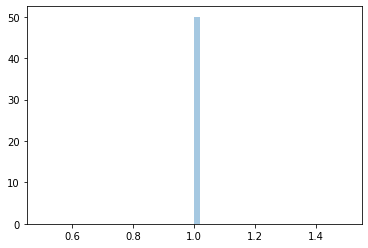

In [327]:
ax=t0.dist()
ax.get_figure().savefig("deseq_wo_replace/"+batch+"/"+batch+"_self_hist.png")

/Users/Yue/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


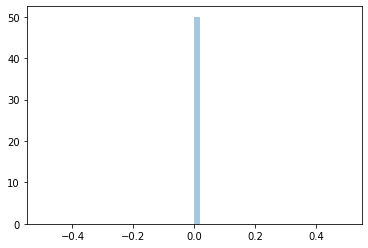

In [328]:
ax=t0.logdist()
ax.get_figure().savefig("deseq_wo_replace/"+batch+"/"+batch+"_self_hist_log.png")

<class 'matplotlib.axes._subplots.AxesSubplot'>


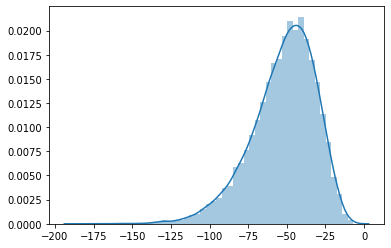

In [329]:
ax=test.logdist()
print(type(ax))
ax.get_figure().savefig("deseq_wo_replace/"+batch+"/"+batch+"_test_hist.png")

In [330]:
from scipy import stats
x = ax.lines[0].get_xdata() # Get the x data of the distribution
y = ax.lines[0].get_ydata() # Get the y data of the distribution
maxid = np.argmax(y) # The id of the peak (maximum of y data)
mode = x[maxid]
logp = np.log(test.ps)
median = np.median(logp)
std=np.std(logp)
print(mode,median,std)

-43.57003009012868 -34.26496649343062 14.406545873411421


In [331]:
left = np.searchsorted(logp,mode-std)
mid = np.searchsorted(logp,mode)
right = np.searchsorted(logp,mode+std)
print(left,mid,right)

805 2701 6513


In [332]:
def disp_save_img(idx,pos):
    num = 50
    for i in range(num):
        seq = test.seqs[i-num//2+idx]
        if i == 0:
            com_seq = seq
        else:
            com_seq.addseqs(seq.seqs)
        img=seq.plotlogo()
        #display(img)
        with open("deseq_wo_replace/"+batch+"/"+pos+str(i)+".png", "wb") as png:
            png.write(img.data)
    img=com_seq.plotlogo()
    #display(img)
    with open("deseq_wo_replace/"+batch+"/"+pos+'_comb'+str(num)+".png", "wb") as png:
        png.write(img.data)
    

disp_save_img(mid,'median')
disp_save_img(left,'leftstd')
disp_save_img(right,'rightstd')

In [333]:
img=target_seq.plotlogo()
with open("deseq_wo_replace/"+batch+"/enriched"+".png", "wb") as png:
    png.write(img.data)
img=bg_seq.plotlogo()
with open("deseq_wo_replace/"+batch+"/background"+".png", "wb") as png:
    png.write(img.data)
img=dep_seq.plotlogo()
with open("deseq_wo_replace/"+batch+"/depleted"+".png", "wb") as png:
    png.write(img.data)

In [12]:
target_seq.seqs

['GCCCCGCCATGGCCGTCAC',
 'CTGCCCGGATGGCAACAGT',
 'TATCCGTGATGGACGATGC',
 'GTGCAGCCATGTCCTCTTC',
 'AGCCCGCAATGTCGGGCCC',
 'CGTCGCGCATGCGCAAACA',
 'AAATAGGGATGCTGAAAAG',
 'GACCGGAGATGGCGCCGCC',
 'TCCTGGCCATGGGGTCGGC',
 'TGCACAAAATGCCCGGCGA',
 'CCCCGGTCATGACAGAGAC',
 'CGGAGGGAATGCCCCGGAG',
 'CAGCCGTCATGGCAGCGGA',
 'GCGAGGAGATGGAGCAGAA',
 'GCGCGGCCATGTTGGAGGC',
 'CGCGAAAGATGCCGGGTCT',
 'TAGGGCGCATGAAGACCAG',
 'CAGGGTTTATGTGTCAGGG',
 'CCGCAAGGATGAGTGCTGC',
 'AGCCAGACATGGGACTGGA',
 'GAGGCGACATGAGTGCCGC',
 'CAAGCAAGATGGCGGAGGA',
 'CGGCCGCGATGAGCGGGGA',
 'TGAATCGGATGGCCTGGAA',
 'AGACTGCGATGACTTCTGC',
 'CGGCGGTCATGCGGGACGC',
 'GTCCCGCCATGTCCCAGAA',
 'CCGCCACGATGCCCAAGAG',
 'CCCCCCAGATGGGGCCTGG',
 'CGGGTTGGATGCTTAAAGC',
 'AGGCCGGGATGGCGGCGGC',
 'GCATCACCATGTCTGTTCG']